In [2]:
import os
import shutil
import random

def split_dataset(original_dir, output_base_dir, split_ratios=(0.7, 0.15, 0.15), seed=42):
    random.seed(seed)
    categories = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    for category in categories:
        src_dir = os.path.join(original_dir, category)
        images = [f for f in os.listdir(src_dir) if f.endswith('.png')]
        random.shuffle(images)

        n_total = len(images)
        n_train = int(split_ratios[0] * n_total)
        n_val = int(split_ratios[1] * n_total)
        
        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split_name, split_files in splits.items():
            dst_dir = os.path.join(output_base_dir, split_name, category)
            os.makedirs(dst_dir, exist_ok=True)
            for fname in split_files:
                shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))


# Example usage:
original_dataset = 'C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_DB_SUBSET/mery'  # Your current folder with 7 emotions
output_dataset = 'C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_subset'        # New folder to hold train/val/test

split_dataset(original_dataset, output_dataset)


In [3]:
import os
import hashlib

def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def hash_all_files(folder):
    hashes = set()
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, f)
                hashes.add(file_hash(full_path))
    return hashes

train_hashes = hash_all_files('C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_subset/train')
val_hashes = hash_all_files('C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_subset/val')
test_hashes = hash_all_files('C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_subset/test')

# Check for overlaps
overlap_train_val = train_hashes.intersection(val_hashes)
overlap_train_test = train_hashes.intersection(test_hashes)
overlap_val_test = val_hashes.intersection(test_hashes)

print(f"Duplicate files between train & val:  {len(overlap_train_val)}")
print(f"Duplicate files between train & test: {len(overlap_train_test)}")
print(f"Duplicate files between val & test:   {len(overlap_val_test)}")

if any([overlap_train_val, overlap_train_test, overlap_val_test]):
    print("DATA LEAKED - splits are not clean.")
else:
    print("No overlap found — splits are clean.")


Duplicate files between train & val:  0
Duplicate files between train & test: 0
Duplicate files between val & test:   0
No overlap found — splits are clean.


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Image size and batch setup
img_size = (64, 64)
batch_size = 32
epochs = 10

# Load data
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    'C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_subset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_directory(
    'C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_subset/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_directory(
    'C:/Users/modik/Downloads/Behavioral Data Science/homework 3/FERG_subset/test',
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False  # important for predictions
)

Found 5287 images belonging to 7 classes.
Found 1131 images belonging to 7 classes.
Found 1140 images belonging to 7 classes.


In [ ]:
# Found 5287 (70%) images belonging to 7 classes → training set: 5287 images spread across 7 emotion categories.
# Found 1131 (15%) images belonging to 7 classes → validation set: 1131 images used to tune the model and detect overfitting.
# Found 1140 (15%) images belonging to 7 classes → test set: 1140 completely unseen images used for final evaluation.

In [6]:
# Build model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


c:\Users\modik\Downloads\Anaconda\envs\behavioral-data-science\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)

c:\Users\modik\Downloads\Anaconda\envs\behavioral-data-science\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.5936 - loss: 1.0325 - val_accuracy: 0.9982 - val_loss: 0.0050
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 0.9991 - val_loss: 0.0035
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.9997 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 1.5383e-04
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 1.0000 - loss: 5.7910e-04 - val_accuracy: 1.0000 - val_loss: 6.0590e-04
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 1.0000 - loss: 6.5733e-04 - val_accuracy: 1.0000 - val_loss: 7.5898e-05
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 1.0000 - loss: 1.4570e-04 - val_accuracy: 1.0000 - val_loss: 2.9506e-05
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.9971 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 1.6205e-04
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/s

In [8]:
# Evaluate
loss, acc = model.evaluate(test_gen)
print(f"Final Test Accuracy: {acc:.4f}")

# Predictions
pred_probs = model.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

1140/1140 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 1.0000 - loss: 1.8796e-06
Final Test Accuracy: 1.0000
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step


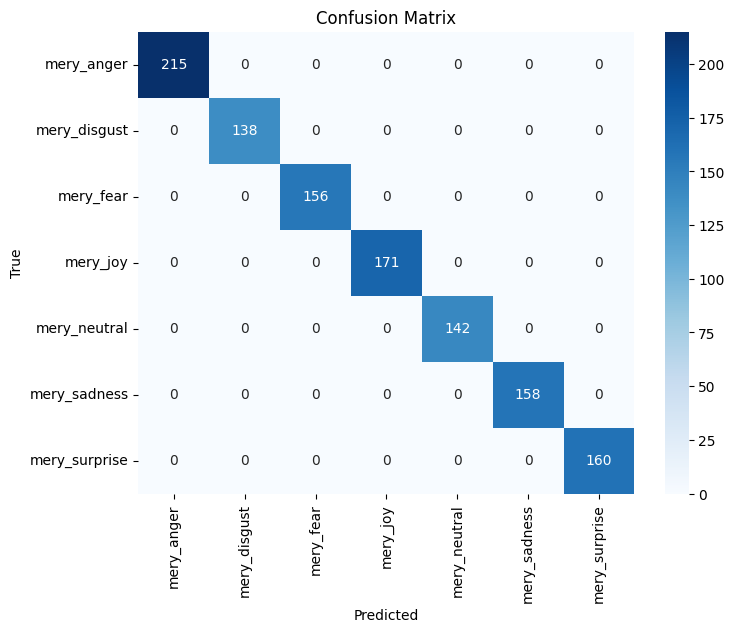

               precision    recall  f1-score   support

   mery_anger       1.00      1.00      1.00       215
 mery_disgust       1.00      1.00      1.00       138
    mery_fear       1.00      1.00      1.00       156
     mery_joy       1.00      1.00      1.00       171
 mery_neutral       1.00      1.00      1.00       142
 mery_sadness       1.00      1.00      1.00       158
mery_surprise       1.00      1.00      1.00       160

     accuracy                           1.00      1140
    macro avg       1.00      1.00      1.00      1140
 weighted avg       1.00      1.00      1.00      1140



In [9]:
# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(true_classes, pred_classes, target_names=class_labels))